# EdNet - PREDICT STUDENT PERFORMANCE
"EdNet is the dataset of all student-system interactions collected over 2 years by Santa, a multi-platform AI tutoring service with more than 780K users in Korea available through Android, iOS and web." https://github.com/riiid/ednet<p>
<b>OBJECTIVE:</b> Predict likelihood that a student will choose a correct answer based on their previous data. <p>
<b>METHOD:</b> Compare many machine learning logistic regression algorithms to determine the most performant model for the students.

In [1]:
# I get by with a little help from my friends
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
cd ~/Desktop/SPRINGBOARD_MASTER/EdNet/data/raw/EdNet-KT4/KT4

C:\Users\Prem\Desktop\SPRINGBOARD_MASTER\EdNet\data\raw\EdNet-KT4\KT4


In [3]:
# save file locations as variables for fast access
prefix = '~/Desktop/SPRINGBOARD_MASTER/EdNet/data/raw/EdNet-'
folder_1 = prefix + 'KT1/KT1/'
folder_2 = prefix + 'KT2/KT2/'
folder_3 = prefix + 'KT3/KT3/'
folder_4 = prefix + 'KT4/KT4/'
questions = prefix + 'Contents/contents/questions.csv'

# read in Answer Key as 'questions_df' csv file
questions_df = pd.read_csv(questions)

# create a list of the csv files in current directory
csv_files = glob.glob('*.csv')

In [4]:
# count of csv files in current directory
print(len(csv_files))

298067


# DATA WRANGLING & CLEANING
1. data import, read csv files as pandas dataframes
2. extract user_id from filename and assign user_id as value to column[0], 'user_id'
3. convert unix timestamps to datetime
4. drop duplicate timestamp rows
5. clean up some values by slicing unhelpful leading letters and convert into integers
6. export as a cleaned up csv

In [5]:
# user number = z
z = 1260

# loop: create pandas dataframe
for i in range(1):
        df = pd.read_csv(folder_1 + csv_files[z])
        df.insert(0, 'user_id', csv_files[z].split('.')[0])
        
        # convert timestamp column to datetime
        df.timestamp = pd.to_datetime(df['timestamp'], unit='ms')
        
        # drop_duplicates
        df = df.drop_duplicates(subset=['timestamp'], keep='last')
        
        # convert 'elapsed_time' from ms to seconds
        df.elapsed_time = df.elapsed_time.div(1000)
        
        # cleanup values by slicing the leading letter
        df.user_id = df.user_id.str.split('u')[1][1]
        df.user_id = df.user_id.astype('int64')
        df.question_id = df.question_id.str.slice(start=1)
        
        #df.question_id = df.question_id.fillna(0).astype(int)

        # EXPORT csv create a csv of the new dataframe
        output = '_KT1_'+ str(csv_files[z])
        df.to_csv(output, index=False)
        
        z+=1

df.head()

,user_id,timestamp,solving_id,question_id,user_answer,elapsed_time
0,12,2019-08-14 05:05:58.044,1,9632,b,15.0
1,12,2019-08-14 05:06:22.342,2,5037,b,20.0
2,12,2019-08-14 05:07:10.824,3,5098,a,46.0
3,12,2019-08-14 05:07:46.344,4,218,b,33.0
4,12,2019-08-14 05:08:28.991,5,5055,d,40.0


In [6]:
df.dtypes

user_id                  int64
timestamp       datetime64[ns]
solving_id               int64
question_id             object
user_answer             object
elapsed_time           float64
dtype: object

# EXPLORATORY DATA ANALYSIS
1. check for null values
2. clean up as needed

[59, 59, 59, 59, 56, 59]


Text(0.5, 1.0, 'Non-Null Values')

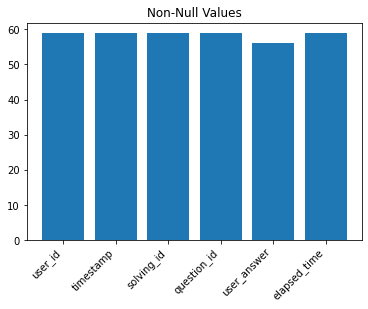

In [7]:
# plot Non-Null Values per column
hey = '_KT1_u' + str(df.iloc[:,0].values[0])
newb = pd.read_csv(hey + '.csv')

newlist = []
for i in range(newb.shape[1]):
    newlist.append(newb.iloc[:,i].notnull().sum())
print(newlist)

import matplotlib.pyplot as plt
plt.bar(newb.columns, newlist)
plt.xticks(rotation=45, ha="right")
plt.title('Non-Null Values')

# DATA CLEANING, SPLITTING & MERGING
1. clean up unneeded leading letters in values
2. split the 'tags' column n times and make a separate column for each tag
3. left inner join student dataframe and answer key dataframe on the 'question_id' column 
4. grade the student against answer key and record in a binary 'correct' column 
5. remove duplicate 'timestamp' rows

In [8]:
# clean 'question_df' dataframe AKA: Answer Key
questions_df.question_id = questions_df.question_id.str.slice(start=1)
questions_df.bundle_id = questions_df.bundle_id.str.slice(start=1)
questions_df.explanation_id = questions_df.explanation_id.str.slice(start=1)
questions_df.deployed_at = pd.to_datetime(questions_df.deployed_at, unit='ms')
dfq = questions_df[['question_id', 'correct_answer', 'bundle_id', 'part', 'tags', 'deployed_at']]
dfq.head()

,question_id,correct_answer,bundle_id,part,tags,deployed_at
0,1,b,1,1,1;2;179;181,2019-05-17 11:40:17.098
1,2,a,2,1,15;2;182,2019-05-17 11:40:19.720
2,3,b,3,1,14;2;179;183,2019-05-17 11:40:22.784
3,4,b,4,1,9;2;179;184,2019-05-17 11:40:25.357
4,5,c,5,1,8;2;179;181,2019-05-17 11:40:28.439


In [9]:
# new data frame with split value columns 
new = dfq['tags'].str.split(";", n = 8, expand = True) 
  
# make a separate column for each tag
dfq['tag1']= new[0] 
dfq['tag2']= new[1] 
dfq['tag3']= new[2]
dfq['tag4']= new[3]
dfq['tag5']= new[4]
dfq['tag6']= new[5]
dfq['tag7']= new[6]
#dfq['tag8']= new[7]

In [10]:
dfq.head()

,question_id,correct_answer,bundle_id,part,tags,deployed_at,tag1,tag2,tag3,tag4,tag5,tag6,tag7
0,1,b,1,1,1;2;179;181,2019-05-17 11:40:17.098,1,2,179,181,None,None,None
1,2,a,2,1,15;2;182,2019-05-17 11:40:19.720,15,2,182,None,None,None,None
2,3,b,3,1,14;2;179;183,2019-05-17 11:40:22.784,14,2,179,183,None,None,None
3,4,b,4,1,9;2;179;184,2019-05-17 11:40:25.357,9,2,179,184,None,None,None
4,5,c,5,1,8;2;179;181,2019-05-17 11:40:28.439,8,2,179,181,None,None,None


In [11]:
# subset df for notnull question_id rows only (only work with rows that have questions)
df2 = df[df['question_id'].notnull()]

In [12]:
# left join student dataframe and answer key dataframe on the 'question_id' column 
dfm = pd.merge(df2, dfq,  how='left', left_on=['question_id'], right_on = ['question_id'])

In [13]:
# create a 'correct' column
dfm['correct'] = np.nan

# loop - if user answers == correct answer, then dfq['correct'][_]= 1
length_df = dfm['user_id'].count()
count = 0
for i in range(length_df):
    if dfm['user_answer'][count] == dfm['correct_answer'][count]:
        dfm['correct'][count] = 1
    if dfm['user_answer'][count] != dfm['correct_answer'][count]:
        dfm['correct'][count] = 0
    count+=1

In [14]:
# inspect new merged dataframe
dfm.head()

,user_id,timestamp,solving_id,question_id,user_answer,elapsed_time,correct_answer,bundle_id,part,tags,deployed_at,tag1,tag2,tag3,tag4,tag5,tag6,tag7,correct
0,12,2019-08-14 05:05:58.044,1,9632,b,15.0,a,6983,5,78,2019-09-17 02:57:58.835,78,None,None,None,None,None,None,0.0
1,12,2019-08-14 05:06:22.342,2,5037,b,20.0,b,3569,5,98,2019-10-17 03:05:12.749,98,None,None,None,None,None,None,1.0
2,12,2019-08-14 05:07:10.824,3,5098,a,46.0,c,3630,5,83,2019-03-12 02:04:33.013,83,None,None,None,None,None,None,0.0
3,12,2019-08-14 05:07:46.344,4,218,b,33.0,b,218,2,24;50;184;185,2019-10-30 05:13:00.056,24,50,184,185,None,None,None,1.0
4,12,2019-08-14 05:08:28.991,5,5055,d,40.0,c,3587,5,119,2019-10-17 03:05:45.729,119,None,None,None,None,None,None,0.0


In [15]:
# organize columns into logical groups
dfm = dfm[['user_id', 'question_id','solving_id','bundle_id','correct','part',\
           'timestamp','deployed_at','elapsed_time','tag1','tag2','tag3','tag4','tag5','tag6','tag7']]

In [16]:
# inspect again
dfm.head()

,user_id,question_id,solving_id,bundle_id,correct,part,timestamp,deployed_at,elapsed_time,tag1,tag2,tag3,tag4,tag5,tag6,tag7
0,12,9632,1,6983,0.0,5,2019-08-14 05:05:58.044,2019-09-17 02:57:58.835,15.0,78,None,None,None,None,None,None
1,12,5037,2,3569,1.0,5,2019-08-14 05:06:22.342,2019-10-17 03:05:12.749,20.0,98,None,None,None,None,None,None
2,12,5098,3,3630,0.0,5,2019-08-14 05:07:10.824,2019-03-12 02:04:33.013,46.0,83,None,None,None,None,None,None
3,12,218,4,218,1.0,2,2019-08-14 05:07:46.344,2019-10-30 05:13:00.056,33.0,24,50,184,185,None,None,None
4,12,5055,5,3587,0.0,5,2019-08-14 05:08:28.991,2019-10-17 03:05:45.729,40.0,119,None,None,None,None,None,None


# PREPROCESSING
1. clean up any null values
2. coerce datatypes
3. split data into TRAIN & TEST sets

[59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5, 5, 5, 0, 0, 0]


Text(0.5, 1.0, 'Non-Null Values')

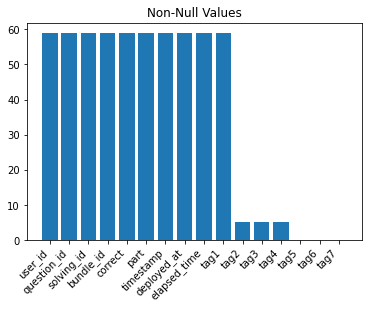

In [17]:
# plot non-null values
newlist = []
for i in range(dfm.shape[1]):
    newlist.append(dfm.iloc[:,i].notnull().sum())
print(newlist)

import matplotlib.pyplot as plt
plt.bar(dfm.columns, newlist)
plt.xticks(rotation=45, ha="right")
plt.title('Non-Null Values')

In [18]:
# convert tag columns: object --> integer
dfm.tag1 = dfm.tag1.fillna(0).astype(int)
dfm.tag2 = dfm.tag2.fillna(0).astype(int)
dfm.tag3 = dfm.tag3.fillna(0).astype(int)
dfm.tag4 = dfm.tag4.fillna(0).astype(int)
dfm.tag5 = dfm.tag5.fillna(0).astype(int)
dfm.tag6 = dfm.tag6.fillna(0).astype(int)
dfm.tag7 = dfm.tag7.fillna(0).astype(int)

# convert correct, question_id, andbundle_id tags to integers
dfm.question_id = dfm.question_id.astype(int)
dfm.bundle_id = dfm.bundle_id.astype(int)
dfm.correct = dfm.correct.astype(int)

In [19]:
# inspect datatypes
dfm.dtypes

user_id                  int64
question_id              int32
solving_id               int64
bundle_id                int32
correct                  int32
part                     int64
timestamp       datetime64[ns]
deployed_at     datetime64[ns]
elapsed_time           float64
tag1                     int32
tag2                     int32
tag3                     int32
tag4                     int32
tag5                     int32
tag6                     int32
tag7                     int32
dtype: object

In [20]:
# drop rows with repeated 'timestamp' & inspect value counts
dfm = dfm.drop_duplicates(subset='timestamp')
dfm.timestamp.value_counts().head(3)

2019-09-17 08:21:17.777    1
2019-08-14 05:08:28.991    1
2019-09-17 08:56:48.146    1
Name: timestamp, dtype: int64

In [21]:
# inspect again
dfm.head(20)

,user_id,question_id,solving_id,bundle_id,correct,part,timestamp,deployed_at,elapsed_time,tag1,tag2,tag3,tag4,tag5,tag6,tag7
0,12,9632,1,6983,0,5,2019-08-14 05:05:58.044,2019-09-17 02:57:58.835,15.0,78,0,0,0,0,0,0
1,12,5037,2,3569,1,5,2019-08-14 05:06:22.342,2019-10-17 03:05:12.749,20.0,98,0,0,0,0,0,0
2,12,5098,3,3630,0,5,2019-08-14 05:07:10.824,2019-03-12 02:04:33.013,46.0,83,0,0,0,0,0,0
3,12,218,4,218,1,2,2019-08-14 05:07:46.344,2019-10-30 05:13:00.056,33.0,24,50,184,185,0,0,0
4,12,5055,5,3587,0,5,2019-08-14 05:08:28.991,2019-10-17 03:05:45.729,40.0,119,0,0,0,0,0,0
5,12,4324,6,2856,0,5,2019-08-14 05:09:07.334,2019-06-24 08:55:57.660,36.0,76,0,0,0,0,0,0
6,12,6448,7,4980,1,5,2019-08-14 05:09:52.512,2019-08-09 08:03:09.775,43.0,85,0,0,0,0,0,0
7,12,4617,8,3149,1,5,2019-08-14 05:10:17.645,2019-08-09 07:54:00.491,23.0,83,0,0,0,0,0,0
8,12,5453,9,3985,1,5,2019-08-14 05:10:36.378,2019-10-17 02:24:35.457,16.0,103,0,0,0,0,0,0
9,12,6256,10,4788,0,5,2019-08-14 05:10:47.587,2018-02-20 04:08:46.897,8.0,78,0,0,0,0,0,0


In [22]:
# list to store to scores
scores = []
algo = []

In [23]:
"""# Standardize the magnitude of numeric features using scaler
from sklearn.preprocessing import StandardScaler
data = dfm[['user_id', 'question_id', 'solving_id', 'bundle_id', 'correct', 'part','elapsed_time', 'tag1', 'tag2', 'tag3', \
            'tag4', 'tag5', 'tag6', 'tag7']]
scaler = StandardScaler()
#data = scaler.fit(data)
#print(scaler.mean_)
#print(scaler.transform(data))"""

"# Standardize the magnitude of numeric features using scaler\nfrom sklearn.preprocessing import StandardScaler\ndata = dfm[['user_id', 'question_id', 'solving_id', 'bundle_id', 'correct', 'part','elapsed_time', 'tag1', 'tag2', 'tag3',             'tag4', 'tag5', 'tag6', 'tag7']]\nscaler = StandardScaler()\n#data = scaler.fit(data)\n#print(scaler.mean_)\n#print(scaler.transform(data))"

In [24]:
#Split data into testing and training datasets
import numpy as np
from sklearn.model_selection import train_test_split
X = dfm[['user_id', 'question_id', 'solving_id', 'bundle_id', 'part','elapsed_time', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'tag7']]
y = dfm.correct

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# MODELLING
1. test and compare the predictive performance of various machine learning algorithms

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
#clf.predict_proba(X_train)
print(lr.score(X_test, y_test))
scores.append(lr.score(X_test, y_test))
algo.append('LogisticRegression')

0.5


In [26]:
"""#clf WRONG!
clf = LogisticRegression(random_state=42).fit(X, y)
clf.predict(X)
clf.predict_proba(X)
clf.score(X, y)
scores.append(clf.score(X, y))
algo.append('clf')"""

"#clf WRONG!\nclf = LogisticRegression(random_state=42).fit(X, y)\nclf.predict(X)\nclf.predict_proba(X)\nclf.score(X, y)\nscores.append(clf.score(X, y))\nalgo.append('clf')"

In [27]:
#clf
clf = LogisticRegression(random_state=42).fit(X, y)
clf.predict(X_test)
clf.predict_proba(X_test)
clf.score(X_test, y_test)
scores.append(clf.score(X_test, y_test))
algo.append('clf')
print(clf.score(X_test, y_test))

0.75


In [28]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
nb.score(X,y)
scores.append(nb.score(X,y))
algo.append('GaussianNB')

In [29]:
# Stochastic gradient descent
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='modified_huber', shuffle=True, random_state=42)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
sgd.score(X,y)
scores.append(sgd.score(X,y))
algo.append('SGDClassifier')

In [30]:
# KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn.score(X,y)
scores.append(knn.score(X,y))
algo.append('KNeighborsClassifier')

In [31]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfm = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=1, \
                            random_state=42, max_features = None, min_samples_leaf = 30)
rfm.fit(X_train, y_train)
y_pred = rfm.predict(X_test)
rfm.score(X,y)
scores.append(rfm.score(X,y))
algo.append('RandomForestClassifier')

In [32]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=0.025, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
svm.score(X,y)
scores.append(svm.score(X,y))
algo.append('SVC')

In [33]:
print(scores)
print(algo)

[0.5, 0.75, 0.6779661016949152, 0.4915254237288136, 0.6440677966101694, 0.4745762711864407, 0.6949152542372882]
['LogisticRegression', 'clf', 'GaussianNB', 'SGDClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'SVC']


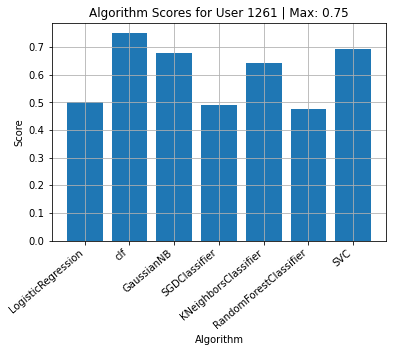

In [34]:
fig, ax = plt.subplots()
plt.bar(algo, scores)
plt.ylabel("Score")
plt.xlabel("Algorithm")
plt.title('Algorithm Scores for User ' +str(z)+ ' | Max: '+str(round(max(scores),5)))
plt.xticks(rotation=40, ha="right" )

ax.grid()

In [35]:
#sf = dfm[dfm.deployed_at[:,:].value == '1969-12-31 23:59:59.999']

In [36]:
"""import seaborn as sns
#plt.plot(dfm.correct, dfm.tag1)
ax = sns.regplot(y=dfm.correct, x=dfm.elapsed_time, color="r")"""

'import seaborn as sns\n#plt.plot(dfm.correct, dfm.tag1)\nax = sns.regplot(y=dfm.correct, x=dfm.elapsed_time, color="r")'

In [37]:
"""# EDA
from pandas_profiling import ProfileReport
profile = ProfileReport(dfm, title="Pandas Profiling Report")

profile.to_widgets()
profile.to_notebook_iframe()"""

'# EDA\nfrom pandas_profiling import ProfileReport\nprofile = ProfileReport(dfm, title="Pandas Profiling Report")\n\nprofile.to_widgets()\nprofile.to_notebook_iframe()'

In [38]:
# best performing model per student
perform = { z : round(max(scores),5) }
perform 

{1261: 0.75}